# Mean-Field Dynamics

In this tutorial we discuss to use TEMPO and the process tensor approach to compute the dynamics of a many-body system of the type introduced in [FowlerWright2021] ([arXiv:2112.09003](http://arxiv.org/abs/2112.09003)).

- [launch binder](https://mybinder.org/v2/gh/tempoCollaboration/OQuPy/HEAD?labpath=tutorials%2Fmf_tempo.ipynb) (runs in browser),
- [download the jupyter file](https://raw.githubusercontent.com/tempoCollaboration/OQuPy/main/tutorials/mf_tempo.ipynb), or
- read through the text below and code along.

**Contents:**

1. Background and introduction
    * many-body system and environment Hamiltonians
    * system Hamiltonian and field equation of motion after the mean-field reduction
2. Creating time-dependent system with field and bath objects
3. TEMPO computation for single dynamics
4. PT-TEMPO computation for multiple sets of dynamics

We firstly import OQuPy and other useful packages:

In [6]:
import sys
sys.path.insert(0,'..')
import oqupy
import numpy as np
import matplotlib.pyplot as plt

Check the current OQuPy version; mean-field functionality was introduced in version **0.3.0**.

In [7]:
oqupy.__version__

'0.3.1'

The following matrices will be useful below:

In [8]:
sigma_z = oqupy.operators.sigma("z")
sigma_plus = oqupy.operators.sigma("+")
sigma_minus = oqupy.operators.sigma("-")

-------------------------------------------------
## 1. Background and introduction

Our goal will be to reproduce a line from **Fig. 2a.** of [FowlerWright2021] ([arXiv:2112.09003](http://arxiv.org/abs/2112.09003)) which shows the photon number dynamics for the driven-dissipative system of molecules in a single-mode cavity.

### Many-body system and environment Hamiltonian
The Hamiltonian describing the many-body system with one-to-all light-matter coupling is
$$
H_{S} = \omega_c a^{\dagger}_{}a^{\vphantom{\dagger}}_{} 
	+ \sum_{i=1}^N \left[\frac{\omega_0}{2} \sigma^z_i
	+  \frac{\Omega}{2\sqrt{N}} \left( a^{\vphantom{\dagger}}_{} \sigma^+_i + a^{\dagger}_{} \sigma^-_i \right)\right]
$$
Together with the vibrational environment of each molecule,
$$
	H_{E}^{(i)} = \sum_{j} \left[	\nu_{j} b^{\dagger}_{j} b^{\vphantom{\dagger}}_{j} 
	+ \frac{\xi_{j}}{2} (b^{\vphantom{\dagger}}_{j}+b^{\dagger}_{j})\sigma^z_i\right]\text{.}
$$
This is taken to be a continuum of low frequency modes with coupling characterized by a spectral density with a 'Gaussian' cut-off
$$
\begin{align*}
J(\nu) &= \sum_{j}  \left(\frac{\xi_j}{2}\right)^2
\delta(\nu-\nu_j)= 2\alpha \nu e^{-(\nu/\nu_c)^2}\text{,} \quad \nu>0\text{,}
\end{align*}
$$
where $\alpha=0.25$ is the unit-less coupling strenght and $\hbar \nu_c = 0.15$ eV is a cutoff frequency for the environment of the BODIPY-Br molecule considered in the Letter. For the numericla simulation we here choose to express all frequencies as angular frequencies in the units of $\frac{1}{\text{ps}}$ (setting $\hbar = k_B = 1$) and all times in units of ps. The parameters relevant to **Fig. 2a.** given in those units are:

* $\nu_c = 0.15 \text{eV} = 227.9 \frac{1}{\text{ps}}$ ... environment cutoff frequency
* $T = 300 \text{K} = 39.3 \frac{1}{\text{ps}}$  ... environment temperature
* $\omega_0 = 0.0 \frac{1}{\text{ps}}$ ... two-level system frequency **\***
* $\omega_c = -0.02 \text{eV} = -30.4 \frac{1}{\text{ps}}$ ... bare cavity frequency
* $\Omega = 0.2 \text{eV} = 303.9 \frac{1}{\text{ps}}$ ... collective light-matter coupling

together with the rates

* $\kappa = 15.2 \frac{1}{\text{ps}}$ ... field decay
* $\Gamma_\downarrow = 15.2 \frac{1}{\text{ps}}$ ... electronic dissipation
* $\Gamma_\uparrow \in (0.2\Gamma_\downarrow, 0.8\Gamma_\downarrow)$ ... electronic pumping

The latter appear as prefactors for Markovian terms in the quantum master equation for the total density operator
$$
\partial_t \rho = -i \biggl[ H_S + \sum_{i=1}^N H_E^{(i)}, \rho \biggr]
	+ 2 \kappa \mathcal{L}[a^{\vphantom{\dagger}}_{}]
	+ \sum_{i=1}^N (\Gamma_\uparrow \mathcal{L}[\sigma^+_i]
	+  \Gamma_\downarrow \mathcal{L}[\sigma^-_i])\text{.}
$$
As indicated, it is the pump strength $\Gamma_\uparrow$ that is varied to generate the different lines of **Fig. 2a.** In this tutorial we generate the $\Gamma_\uparrow=0.8\,\Gamma_\downarrow$ line using the TEMPO method, and then the Process Tensor approach to calculate all of the lines efficiently.  

The following code box defines each of the above parameters.


**\* N.B.** for calculating the dynamics only the detuning $\omega_c-\omega_0$ is relevant, so we set $\omega_0=0$ for convenience.

In [21]:
alpha = 0.25
nu_c = 227.9
T = 39.3
omega_0 = 0.0
omega_c = -30.4
Omega = 303.9

kappa = 15.2
Gamma_down = 15.2
Gamma_up = 0.8 * Gamma_down

### System Hamiltonian and field equation of motion after the mean-field reduction

The mean-field approach is based on a product-state ansatz for the total density operator $\rho$,
$$
\rho = \rho_a \otimes \bigotimes_{i=1}^N \rho_i,\quad \rho_a= \text{Tr}_{\otimes{i}}\rho,\quad \rho_i = \text{Tr}_{a, \otimes{j\neq i}} \rho,
$$ 
where $\text{Tr}_{\otimes{i}}$ denotes a partial trace taken over the Hilbert space of all two-level systems and $\text{Tr}_{a, \otimes{j\neq i}}$ the trace over the photonic degree of freedom and all but the $i^{\text{th}}$ two-level system. As detailed in the Supplement of the Letter, after rescaling the field $\langle a \rangle \to \langle a \rangle/\sqrt{N}$ ($\langle a \rangle$ scales with $\sqrt{N}$ in the lasing phase), the dynamics are controlled by the mean-field Hamiltonian $H_{\text{MF}}$ for a *single molecule,*
$$
	H_\text{MF} = 
 \frac{\omega_0}{2}\sigma^z+
	\frac{\Omega}{2}\left( \langle a \rangle \sigma^+ +
	\langle a \rangle^{*}\sigma^- \right)\text{,}
$$
together with the equation of motion for the field $\langle a \rangle$,
$$
\partial_t \langle a \rangle = 
	- (i\omega_c+\kappa)\langle a \rangle- i \frac{\Omega}{2}\langle\sigma^-\rangle.
$$
Therefore in order to calculate the dynamics we need to encode the field's equation of motion in addition to the Hamiltonian for a single two level-system $\rho_i$. This is done in OQuPy using the `MeanFieldSystem` class.

## 2. Creating time-dependent system with field and bath objects
A `MeanFieldSystem` object is initialised with a field equation of motion and one or more `TimeDependentSystemWithField` which objects in turn are characterised by Hamiltonians with both time and field depedence. In the present example, we need only one `TimeDependentSystemWithField`, for the single molecule Hamiltonian $H_{\text{MF}}$, but other problems may require multiple such objects e.g. to encode different types of molecules.

We firstly need to define:   
- a function `field_eom(t, state_list, a)` which takes as arguments time, a _list_ of states as square matrices (numpy ndarrays) and a field
- a function `H_MF(t, a)` which takes a time and a field
    
Since positional arguments are used in the definition of these functions, the order of arguments matter, whereas their names do not. In particular, both functions must have a time variable for their first argument, even if there happens to be no explicit time-dependence in the problem (there is no '`SystemWithField`' class in OQuPy). 

In [22]:
def H_MF(t, a):
    return 0.5 * omega_0 * sigma_z +\
        0.5 * Omega * (a * sigma_plus + np.conj(a) * sigma_minus)
def field_eom(t, state_list, a):
    state = state_list[0]
    expect_val = np.matmul(sigma_minus, state).trace()
    return -(1j * omega_c + kappa) * a - 0.5j * Omega * expect_val

Note that the second argument of `field_eom` must be a list, even in the case of a single `TimeDependentSystemWithField` object (this requirement is a feature of most functionality involving the `MeanFieldSystem` class, as we will see below). Thus, in order to compute the expectation $\langle \sigma^- \rangle$ we took the first element of this list - a $2\times2$ matrix - before multiplying by $\sigma^-$ and taking the trace.

It is a good idea to test these functions:

In [23]:
test_field = 1.0+1.0j
test_time = 0.01
test_state_list = [ np.array([[0.0,2j],[-2j,1.0]]) ]
print('H_eval =', H_MF(test_time, test_field))
print('EOM_eval =', field_eom(test_time, test_state_list, test_field))

H_eval = [[  0.    +0.j   151.95+151.95j]
 [151.95-151.95j   0.    +0.j  ]]
EOM_eval = (258.29999999999995+15.2j)


In, we need to specify Lindblad operators for the pumping and dissipation processes:

In [24]:
gammas = [ lambda t: Gamma_down, lambda t: Gamma_up]
lindblad_operators = [ lambda t: sigma_minus, lambda t: sigma_plus]

Here the rates and Lindblad operators must be callables taking a single argument - time - again, even though in our example there is no explicit time-dependence. The `TimeDependentSystemWithField` object is then constructed as

In [25]:
system = oqupy.TimeDependentSystemWithField(
        hamiltonian=H_MF,
        gammas=gammas,
        lindblad_operators=lindblad_operators)

and the encompasing `MeanFieldSystem` as

In [26]:
system_list = [system] # a list of TimeDependentiSystemWithField objects
mean_field_system = oqupy.MeanFieldSystem(
                    system_list=system_list,
                    field_eom=field_eom)

where we note the single system must be placed in a list, `system_list`, before being passed to the `MeanFieldSystem` constructor.

Correlations and a Bath object are created in the same way as in any other TEMPO computation (refer to preceding tutorials), although here we will need the Bath in a list:

In [27]:
correlations = oqupy.PowerLawSD(alpha=alpha,
                                zeta=1,
                                cutoff=nu_c,
                                cutoff_type='gaussian',
                                temperature=T)
bath = oqupy.Bath(0.5 * sigma_z, correlations)
bath_list = [bath]

## 3. TEMPO computation for single dynamics

For our simulations we use the same initial conditions for the system and state used in the Letter:

In [28]:
initial_field = np.sqrt(0.05) # Note n_0 = <a^dagger a>(0) = 0.05
initial_state = np.array([[0,0],[0,1]]) # spin down
initial_state_list = [initial_state] # initial state must be provided in a list

To reduce the computation time we simulate only the first 0.3 ps of the dynamics with much rougher convergence parameters compared to the letter.

In [29]:
tempo_parameters = oqupy.TempoParameters(dt=3.2e-3, dkmax=20, epsrel=10**(-5))
start_time = 0.0
end_time = 0.3

The `oqupy.TempoWithField.compute` method may then be used to compute the dynamics in an analogous way a call to `oqupy.Tempo.compute` is used to compute the dynamics for an ordinary `System`:

In [30]:
tempo_sys = oqupy.TempoWithField(mean_field_system=mean_field_system,
                                 bath_list=[bath],
                                 initial_state_list=initial_state_list,
                                 initial_field=initial_field,
                                 start_time=start_time,
                                 parameters=tempo_parameters)
mean_field_dynamics = tempo_sys.compute(end_time=end_time)

--> TEMPO-with-field computation:
100.0%   93 of   93 [########################################] 00:00:12
Elapsed time: 12.9s


`TempoWithField.compute` returns a `MeanFieldSystemDynamics` object containing an array of timesteps, the field values at these timesteps, and a list of ordinary `Dynamics` objects, one for each of `TimeDependentSystemWithField` objects (here only one):

In [31]:
times = mean_field_dynamics.times
fields = mean_field_dynamics.fields
system_dynamics = mean_field_dynamics.system_dynamics[0]
states = system_dynamics.states

We plot a the square value of the fields i.e. the photon number, producing the first part of a single line of **Fig. 2a.**:
    

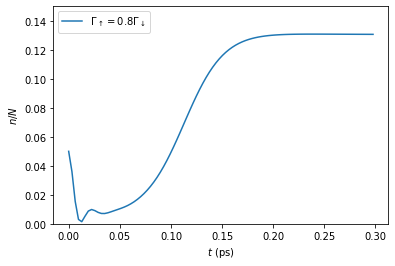

In [32]:
n = np.abs(fields)**2
plt.plot(times, n, label=r'$\Gamma_\uparrow = 0.8\Gamma_\downarrow$')
plt.xlabel(r'$t$ (ps)')
plt.ylabel(r'$n/N$')
plt.ylim((0.0,0.15))
plt.legend(loc='upper left')

If you have the time you can calculate the dynamics to $t=1.3\,\text{ps}$ as in the Letter and check that, even for these very rough parameters, the results are reasonably close to being converged with respect to `dt`, `dkmax` and `epsrel`.

While you could repeat the TEMPO computation for each pump strength $\Gamma_\uparrow$ appearing in **Fig. 2a.**, a more efficient solution for calculating dynamics for multiple sets of system parameters (in this case Lindblad rates) is provided by PT-TEMPO.

## 4. PT-TEMPO computation for multiple sets of dynamics
The above calculation can be performed quickly for many-different pump strengths  $\Gamma_\uparrow$ using a single process tensor. 

As discussed in the Supplement Material for the Letter, there is no guarantee that computational parameters that gave a set of converged results for the TEMPO method will give converged results for a PT-TEMPO calculation. For the sake of this tutorial however let's assume the above parameters continue to be reasonable. The process tensor to time $t=0.3\,\text{ps}$ is calculated using these parameters and the bath via

In [35]:
process_tensor = oqupy.pt_tempo_compute(bath=bath,
                                        start_time=0.0,
                                        end_time=0.3,
                                        parameters=tempo_parameters)

--> PT-TEMPO computation:
100.0%   93 of   93 [########################################] 00:00:03
Elapsed time: 3.2s


Refer the Time Dependence and PT-TEMPO tutorial for further discussion of the process tensor.

To calculate the dynamics for the 4 different pump strengths in **Fig. 2a.**, we define a separate `MeanFieldSystem` object for each pump strength. Only the `gammas` array needs to be modified between sets of constructor calls:

In [33]:
pump_ratios = [0.2, 0.4, 0.6, 0.8]
mean_field_systems = []
for ratio in pump_ratios:
    Gamma_up = ratio * Gamma_down
    # N.B. a default argument is used to avoid the late-binding closure issue
    # discussed here: https://docs.python-guide.org/writing/gotchas/#late-binding-closures
    gammas = [ lambda t: Gamma_down, lambda t, Gamma_up=Gamma_up: Gamma_up]
     # Use the same Hamiltonian, equation of motion and Lindblad operators
    system = oqupy.TimeDependentSystemWithField(H_MF,
        gammas=gammas,
        lindblad_operators=lindblad_operators)
    mean_field_system = oqupy.MeanFieldSystem(system_list=[system],
                                             field_eom=field_eom)
    mean_field_systems.append(mean_field_system)

We can then use `compute_dynamics_with_field` to compute the dynamics at each $\Gamma_\uparrow$ for the particular initial condition using the process tensor (now in a list) calculated above:

In [36]:
t_list = []
n_list = []
for i, mean_field_system in enumerate(mean_field_systems):
    mean_field_dynamics = oqupy.compute_dynamics_with_field(
        process_tensor_list=[process_tensor],
        mean_field_system=mean_field_system,
        initial_state_list=[initial_state],
        initial_field=initial_field,
        start_time=0.0)
    t = mean_field_dynamics.times
    fields = mean_field_dynamics.fields
    n = np.abs(fields)**2
    t_list.append(t)
    n_list.append(n)

--> Compute dynamics with field:
100.0%   93 of   93 [########################################] 00:00:09
Elapsed time: 9.3s
--> Compute dynamics with field:
100.0%   93 of   93 [########################################] 00:00:08
Elapsed time: 8.9s
--> Compute dynamics with field:
100.0%   93 of   93 [########################################] 00:00:10
Elapsed time: 10.5s
--> Compute dynamics with field:
100.0%   93 of   93 [########################################] 00:00:11
Elapsed time: 11.2s


Finally, plotting the results:

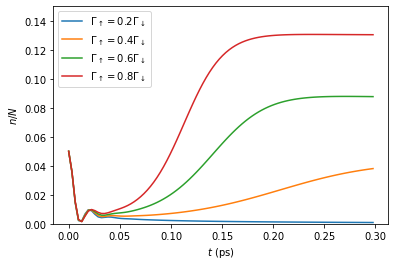

In [37]:
for i,n in enumerate(n_list):
    ratio = pump_ratios[i]
    label = r'$\Gamma_\uparrow = {}\Gamma_\downarrow$'.format(pump_ratios[i])
    plt.plot(t_list[i], n_list[i], label=label)
plt.xlabel(r'$t$ (ps)')
plt.ylabel(r'$n/N$')
plt.ylim((0.0,0.15))
plt.legend(loc='upper left')